# Block processing

Estimating the impulse response by doing estimation on multiple blocks of time and aggregating the separate block results into a combined impulse response (e.g. averaging, median, etc.)

Resources:
- [Cuki’s IR generator Light](http://acousticir.free.fr/spip.php?article169)

In [42]:
import time

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

import scipy.signal
from IPython.display import display, Audio

In [2]:
INPUT_FILE = "data/martin_dcx1re_c414_left_pickup_right.wav"

In [3]:
data, sample_rate_Hz = sf.read(INPUT_FILE)
ydata, xdata = data.T

In [26]:
def freqresp(H, fig, ax1, ax2):
    f = np.linspace(0, sample_rate_Hz, len(H))
    end = len(f)//2
    f_ = f[0:end]
    ax1.semilogx(f_, 20*np.log10(np.abs(H[0:end])))
    ax2.semilogx(f_, np.rad2deg(np.unwrap(np.angle(H[0:end]))))
      
    for ax in (ax1, ax2):
        ax.grid()
    fig.tight_layout()

def phase_at_distance(f, d):
    c = 343
    lamb = np.ma.divide(c, f)
    k = 2*np.pi/lamb
    return -d*k

## Naive deconvolution

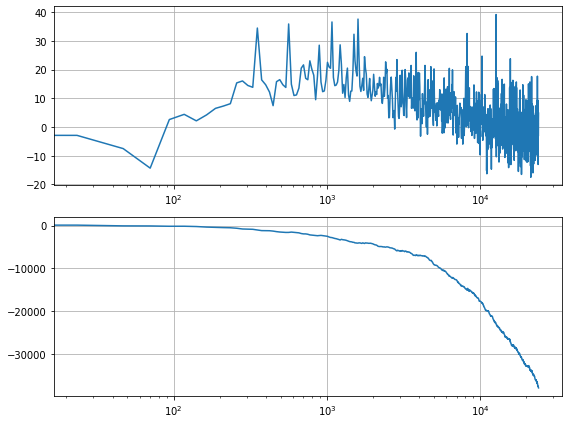

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

w = np.blackman(len(xdata))
X = np.fft.fft(w * xdata, 2048)
Y = np.fft.fft(w * ydata, 2048)
H_naive = Y/X

freqresp(H_naive, fig, ax1, ax2)

## Deconvolution using block processing

In [28]:
def estimate_frequency_response(x, y, size=None):
    if size is None:
        size = len(x)
    w = np.blackman(len(x))
    X = np.fft.fft(x * w, size)
    Y = np.fft.fft(y * w, size)
    H = Y/X
    return H

def block_generator(xdata, ydata, size):
    N = len(xdata)
    assert N == len(xdata) == len(ydata)
    for n in range(0, N, size):
        start = n
        stop = n + size
        if stop > N:
            break
        yield xdata[start:stop], ydata[start:stop]

L = 2048

H_blocks = np.array([
    estimate_frequency_response(x, y)
    for x, y in block_generator(xdata, ydata, L)
])

In [90]:
H_abs = np.median(np.abs(H_blocks), axis=0)
# H_ang = np.median(np.unwrap(np.angle(H_blocks)), axis=0)
# f = np.linspace(0, sample_rate_Hz, len(H_abs))
# H_ang = phase_at_distance(f=f, d=1.0)
H_ang = np.angle(H_naive)
H = H_abs * np.exp(1j*H_ang)

h = np.real(np.fft.ifft(H))
n = np.arange(len(h))
fade1 = ((-n + 2048)*(n>1024) + 1024*(n <=1024)) / 1024
fade2 = (-n + 2048)/2048
h *= fade2

H = np.fft.fft(h)

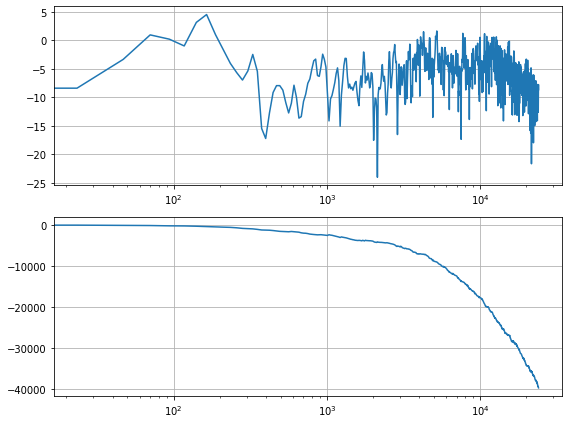

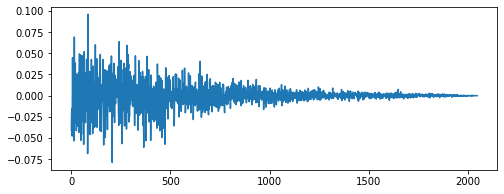

In [91]:
# Frequency response
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

#freqresp(H_naive, fig, ax1, ax2)
freqresp(H, fig, ax1, ax2)

# Inpulse response
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(h)

# sf.write(f"_ir_{int(time.time())}.wav", h, samplerate=sample_rate_Hz)
pass

In [ ]:
# Convolve with the pickup signal
ydata_estimate = np.convolve(xdata, h)

sf.write("_output.wav", ydata_estimate, samplerate=sample_rate_Hz)
display(Audio("_output.wav"))

In [ ]:
sf.write("_pickup.wav", xdata, samplerate=sample_rate_Hz)
display(Audio("_pickup.wav"))

sf.write("_microphone.wav", ydata, samplerate=sample_rate_Hz)
display(Audio("_microphone.wav"))

## Conclusion

This does not look correct. There is almost no frequency-dependency except at DC.